First, we need to import the relate package. The related packages have been installed in student38.

In [3]:
pip install dlib mediapipe opencv-python numpy scikit-image

  Using cached dlib-19.24.6-cp39-cp39-macosx_15_0_universal2.whl
    PyYAML (>=5.1.*)
            ~~~~~~^
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import cv2
import dlib
from scipy.spatial import Delaunay
import sys
from matplotlib import pyplot as plt

This is the first image we use, this image will upload to student38 though web UI.

The original image:


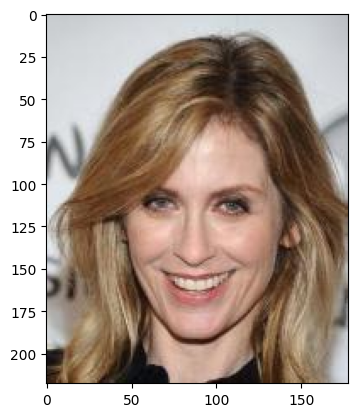

In [11]:
img1 = cv2.imread("./demo/find.jpg")
print("The original image:")
show_img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img)
plt.show()

This is the second image we use, this image looks same like the input image based on the attributes we got by the well-trained model. Such as they all have long curly blond hair and big small.

The similar image:


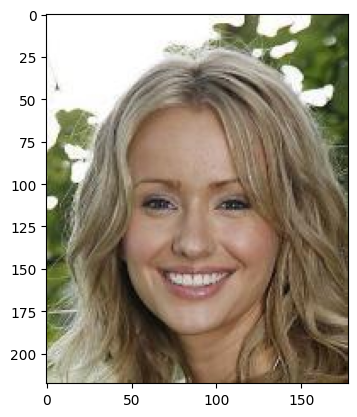

In [12]:
img2 = cv2.imread("./demo/new.jpg")
print("The similar image:")
show_img = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img)
plt.show()

Now we define the dlib model we use. In this tesk, we will use the **shape_predictor_68_face_landmarks.dat**, and more information about this model can be found in [dlib model](https://github.com/davisking/dlib-models).

In [13]:
predictor_model = 'shape_predictor_68_face_landmarks.dat'

Now we define the **get_points** function to get the face landmarks(68 points) and image frame coordinates(8 points). 

In [14]:
def get_points(image):
    
    # Use dlib to get the face landmarks(68 points)
    face_detector = dlib.get_frontal_face_detector()
    face_pose_predictor = dlib.shape_predictor(predictor_model)
    try:
        detected_face = face_detector(image, 1)[0]
    except:
        print('No face detected in image {}'.format(image))
    pose_landmarks = face_pose_predictor(image, detected_face)
    points = []
    for p in pose_landmarks.parts():
        points.append([p.x, p.y])

    # Add 8 image frame coordinate points
    x = image.shape[1] - 1
    y = image.shape[0] - 1
    points.append([0, 0])
    points.append([x // 2, 0])
    points.append([x, 0])
    points.append([x, y // 2])
    points.append([x, y])
    points.append([x // 2, y])
    points.append([0, y])
    points.append([0, y // 2])

    return np.array(points)

Now we print the face landmarks points in two images.

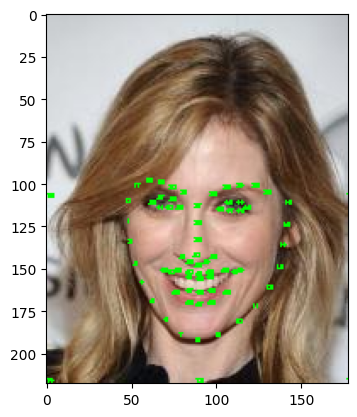

In [18]:
points1 = get_points(img1)
img1_show = np.zeros(img１.shape,np.uint8)
img1_show = img１.copy()  
for idx, point in enumerate(points1):
    pos = (point[0], point[1])
    cv2.putText(img1_show,str(idx),pos,fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,fontScale=0.1,color=(0,255,0))
show_img = cv2.cvtColor(img1_show, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img)
plt.show()

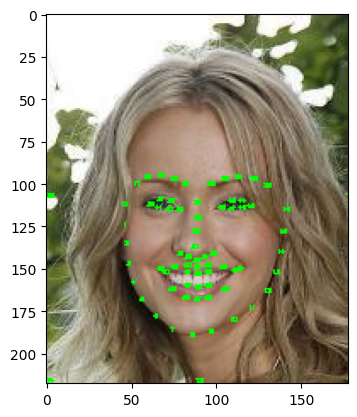

In [17]:
points2 = get_points(img2)
img2_show = np.zeros(img2.shape,np.uint8)
img2_show = img2.copy()
for idx, point in enumerate(points2):
    pos = (point[0], point[1])
    cv2.putText(img2_show,str(idx),pos,fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,fontScale=0.1,color=(0,255,0))
show_img = cv2.cvtColor(img2_show, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img)
plt.show()

Now we define alpha as the merge percentage of these two image.

In [20]:
alpha = 0.5
# Calculate the average coordinates of points in two images
points = (1 - alpha) * np.array(points1) + alpha * np.array(points2)
print (points[0:10])

[[ 46.  112. ]
 [ 46.  124. ]
 [ 47.  135.5]
 [ 49.  148. ]
 [ 52.5 159. ]
 [ 58.  169.5]
 [ 66.  180. ]
 [ 75.5 188.5]
 [ 86.5 191.5]
 [ 98.  189. ]]


Now we define an all-zero matrix **img_morphed** to store the merge image.

In [22]:
img1 = np.float32(img1)
img2 = np.float32(img2)
img_morphed = np.zeros(img1.shape, dtype=img1.dtype)

**get_triangles** function is defined to use the [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation) to process the feature points in images.

In [23]:
def get_triangles(points):
    return Delaunay(points).simplices

The orininal image with Delaunay triangulation:


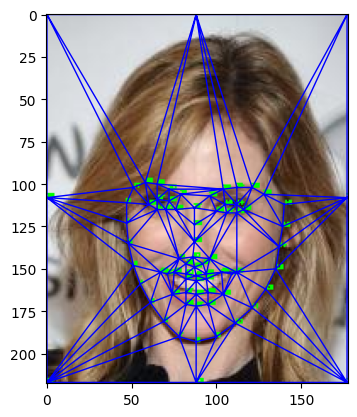

In [24]:
triangles1 = get_triangles(points1)
print ("The orininal image with Delaunay triangulation:")
show_img = cv2.cvtColor(img１_show, cv2.COLOR_BGR2RGB) 
plt.triplot(points1[:,0], points1[:,1], triangles1,linewidth=1,color='b')
plt.imshow(show_img)
plt.show()

The similar image with Delaunay triangulation:


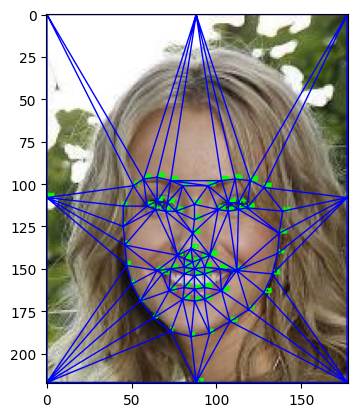

In [25]:
triangles2 = get_triangles(points2)
print ("The similar image with Delaunay triangulation:")
show_img = cv2.cvtColor(img2_show, cv2.COLOR_BGR2RGB) 
plt.triplot(points2[:,0], points2[:,1], triangles2,linewidth=1,color='b')
plt.imshow(show_img)
plt.show()

In [27]:
triangles = get_triangles(points)

We define **affine_transform** to accomplish the affine transform for hte image based on the Delaunay triangulation result.

In [28]:
def affine_transform(input_image, input_triangle, output_triangle, size):
    warp_matrix = cv2.getAffineTransform(
        np.float32(input_triangle), np.float32(output_triangle))
    output_image = cv2.warpAffine(input_image, warp_matrix, (size[0], size[1]), None,
                                  flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    return output_image

In [29]:
for i in triangles:
    
    # Calculate the frame of triangles
    x = i[0]
    y = i[1]
    z = i[2]

    tri1 = [points1[x], points1[y], points1[z]]
    tri2 = [points2[x], points2[y], points2[z]]
    tri = [points[x], points[y], points[z]]
    
    rect1 = cv2.boundingRect(np.float32([tri1]))
    rect2 = cv2.boundingRect(np.float32([tri2]))
    rect = cv2.boundingRect(np.float32([tri]))

    tri_rect1 = []
    tri_rect2 = []
    tri_rect_warped = []
    
    for i in range(0, 3):
        tri_rect_warped.append(((tri[i][0] - rect[0]), (tri[i][1] - rect[1])))
        tri_rect1.append(((tri1[i][0] - rect1[0]), (tri1[i][1] - rect1[1])))
        tri_rect2.append(((tri2[i][0] - rect2[0]), (tri2[i][1] - rect2[1])))
    
    # Accomplish the affine transform in triangles
    img1_rect = img1[rect1[1]:rect1[1] + rect1[3], rect1[0]:rect1[0] + rect1[2]]
    img2_rect = img2[rect2[1]:rect2[1] + rect2[3], rect2[0]:rect2[0] + rect2[2]]

    size = (rect[2], rect[3])
    warped_img1 = affine_transform(img1_rect, tri_rect1, tri_rect_warped, size)
    warped_img2 = affine_transform(img2_rect, tri_rect2, tri_rect_warped, size)
    
    # Calculate the result based on alpha
    img_rect = (1.0 - alpha) * warped_img1 + alpha * warped_img2

    # Generate the mask
    mask = np.zeros((rect[3], rect[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(tri_rect_warped), (1.0, 1.0, 1.0), 16, 0)

    # Accomplish the mask in the merged image
    img_morphed[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]] = \
        img_morphed[rect[1]:rect[1] + rect[3], rect[0]:rect[0] +
            rect[2]] * (1 - mask) + img_rect * mask


In [30]:
img_morphed = np.uint8(img_morphed)

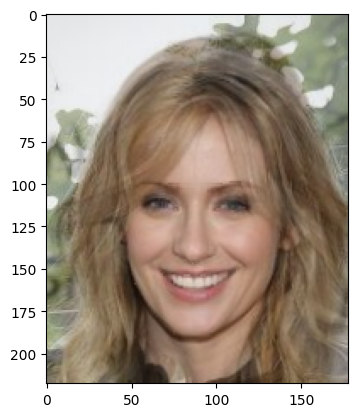

In [32]:
show_img = cv2.cvtColor(img_morphed, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img)
plt.show()

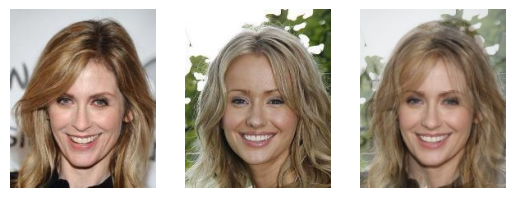

In [34]:
plt.subplot(1,3,1)     
img1_original = cv2.imread("./demo/find.jpg")
show_img = cv2.cvtColor(img1_original, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img) 
plt.axis('off') 

plt.subplot(1,3,2)     
img2_original = cv2.imread("./demo/new.jpg")
show_img = cv2.cvtColor(img2_original, cv2.COLOR_BGR2RGB)  
plt.imshow(show_img)   
plt.axis('off') 

plt.subplot(1,3,3)     
show_img = cv2.cvtColor(img_morphed, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img)
plt.axis('off') 
plt.show()